<a href="https://colab.research.google.com/github/Vkavyasree732/Repository1/blob/main/MHC2024008.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## importing modules

In [ ]:
from google.colab import files
files.upload()

Saving cool-dog.jpeg to cool-dog (2).jpeg


{'cool-dog (2).jpeg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00H\x00H\x00\x00\xff\xe1\x00\xc6Exif\x00\x00MM\x00*\x00\x00\x00\x08\x00\x06\x01\x12\x00\x03\x00\x00\x00\x01\x00\x01\x00\x00\x01\x1a\x00\x05\x00\x00\x00\x01\x00\x00\x00V\x01\x1b\x00\x05\x00\x00\x00\x01\x00\x00\x00^\x01(\x00\x03\x00\x00\x00\x01\x00\x02\x00\x00\x01;\x00\x02\x00\x00\x00\t\x00\x00\x00f\x87i\x00\x04\x00\x00\x00\x01\x00\x00\x00p\x00\x00\x00\x00\x00\x00\x00H\x00\x00\x00\x01\x00\x00\x00H\x00\x00\x00\x01Sergeeva\x00\x00\x00\x06\x90\x00\x00\x07\x00\x00\x00\x040210\x91\x01\x00\x07\x00\x00\x00\x04\x01\x02\x03\x00\xa0\x00\x00\x07\x00\x00\x00\x040100\xa0\x01\x00\x03\x00\x00\x00\x01\x00\x01\x00\x00\xa0\x02\x00\x04\x00\x00\x00\x01\x00\x00\x02d\xa0\x03\x00\x04\x00\x00\x00\x01\x00\x00\x01\x98\x00\x00\x00\x00\xff\xed\x00TPhotoshop 3.0\x008BIM\x04\x04\x00\x00\x00\x00\x00\x1c\x1c\x01Z\x00\x03\x1b%G\x1c\x02\x00\x00\x02\x00\x02\x1c\x02P\x00\x08Sergeeva8BIM\x04%\x00\x00\x00\x00\x00\x10\xcdy@\xad\x1c\xdaO\xec\xf2v\xdegp\xe4\x

In [ ]:
from google.colab import files
import torch
import torch.nn as nn
import torchvision.transforms as T
import torch.nn.functional as F
import cv2
from torchvision.models import resnet18
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from scipy.ndimage import gaussian_filter

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## gradCam

In [ ]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        target_layer = dict([*self.model.named_modules()])[self.target_layer]
        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_image, target_class):
        output = self.model(input_image)
        self.model.zero_grad()
        class_score = output[0, target_class]
        class_score.backward(retain_graph=True)

        gradients = self.gradients.cpu().detach().numpy()[0]
        activations = self.activations.cpu().detach().numpy()[0]

        # Weighted combination of gradients and activations
        weights = np.mean(gradients, axis=(1, 2))
        cam = np.zeros(activations.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * activations[i]

        # Normalize and apply Gaussian smoothing
        cam = np.maximum(cam, 0)
        cam = gaussian_filter(cam, sigma=1)
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam) + 1e-10)  # Avoid division by zero
        return cam





## Preprocessing for custom image

In [ ]:
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    transform = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = transform(image).unsqueeze(0)
    return image.to(device)

In [ ]:
image_path = "cool-dog.jpeg"
input_image = preprocess_image(image_path)

In [ ]:
model = resnet18(pretrained=True).to(device)
model.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
target_class = 207  # Modify this according to the class index you want to visualize
grad_cam = GradCAM(model, target_layer="layer4")
cam = grad_cam.generate_cam(input_image, target_class)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


In [ ]:
cam_resized = np.uint8(255 * cam)
cam_resized = Image.fromarray(cam_resized).resize((224, 224), Image.Resampling.LANCZOS)

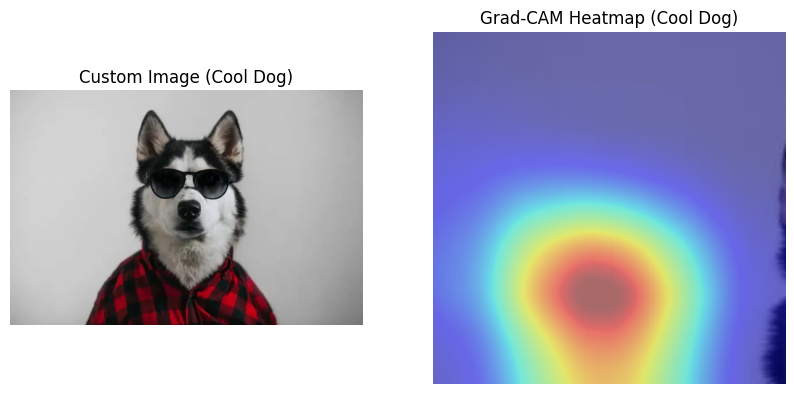

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(Image.open(image_path))
plt.title("Custom Image (Cool Dog)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(Image.open(image_path))
plt.imshow(cam_resized, cmap='jet', alpha=0.5)
plt.title("Grad-CAM Heatmap (Cool Dog)")
plt.axis('off')
plt.show()

In [ ]:
cam_resized = np.array(cam_resized)

if cam_resized.dtype != np.uint8:
    cam_resized = (255 * cam_resized).astype(np.uint8)


In [ ]:
import cv2

cam_color = cv2.applyColorMap(cam_resized, cv2.COLORMAP_JET)
cam_color = cv2.cvtColor(cam_color, cv2.COLOR_BGR2RGB)


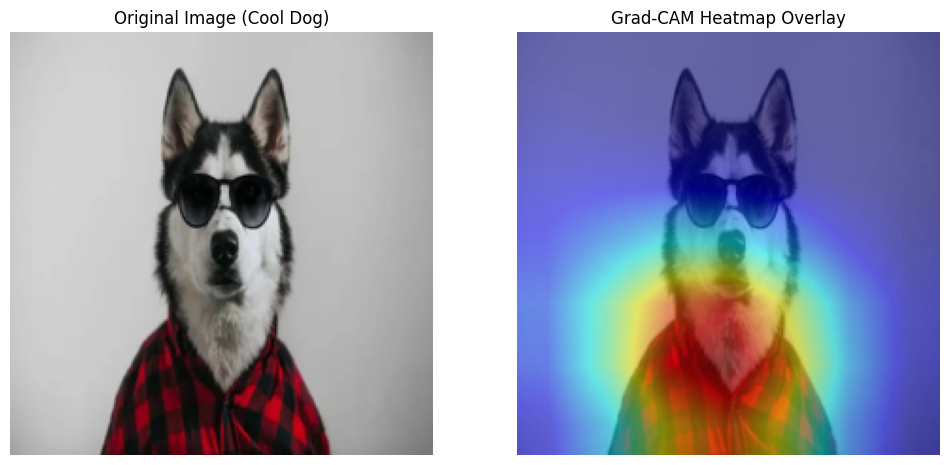

In [ ]:
cam_resized = np.uint8(255 * cam)
cam_resized = cv2.resize(cam_resized, (224, 224))
cam_color = cv2.applyColorMap(cam_resized, cv2.COLORMAP_JET)
cam_color = cv2.cvtColor(cam_color, cv2.COLOR_BGR2RGB)

original_image = Image.open(image_path).resize((224, 224))
original_image = np.array(original_image)

alpha = 0.5
overlay = cv2.addWeighted(original_image, 1 - alpha, cam_color, alpha, 0)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title("Original Image (Cool Dog)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(overlay)
plt.title("Grad-CAM Heatmap Overlay")
plt.axis('off')

plt.show()


* custom cnn is bad as its accuracy is bad.
* pretrained model accurately finds the accurate grad map.